# Gethermal energy paper
In this notebook, I'll read all the sheets in the excel files provide by Hamid, and save them in csv files. Then I'll load and analyze them.
For a weird reason, all the units in this notebook are SI, except for energy and exergy that are reported in kJ instead of J.
Sometimes, I forget to say that the units are kJ/s and not kJ. I try to fix, otherwise figure it out for yourselves.  
BE CAREFUL: always run this notebook by choosing `run all` from the cell menu.

## power plant efficiency and emission factors
I have calculated the efficiency factors of the fossil fuel power plants. Here, I need to use the chemical exergy and CO2 emission of coal and natural gas to estimate the CO2 emission of the power plants. Let's go to work:

In [1]:
# efficiency factors
η_pc   = 0.34 # pulverized coal power plant efficiency
η_igcc = 0.40 # integrated gasification combined cycle
η_ngcc = 0.45 # natural gas combined cycle

# fossil fuels chemical exergy
MW_CO2  = 0.044 # kg/mol
# 1- coal; formula: CH
ex_coal = 400 + 100      # kJ/mol
MW_coal = 12 + 1         # g/mol
em_coal = MW_CO2/ex_coal # kg CO2/J chemical exergy
# 2- natural gas; formula: CH4
ex_gas  = 400 + 4*100   # kJ/mol
MW_gas  = 12 + 4        # g/mol
em_gas  = MW_CO2/ex_gas # kg CO2/kJ chemical exergy

e_pc    = em_coal/η_pc   # kg CO2/kJ electricity
e_igcc  = em_coal/η_igcc # kg CO2/kJ electricity
e_ngcc  = em_gas/η_ngcc  # kg CO2/kJ electricity

0.00012222222222222221

The above numbers will be used later in the exergy analysis below.

In [2]:
using DataFrames, PyPlot, CoolProp, Dierckx
PyPlot.svg(true)
p0 = 101325 # [Pa]
T0 = 20+273.15 # [K]

INFO: Recompiling stale cache file /home/ali/.julia/lib/v0.5/SHA.ji for module SHA.
INFO: Recompiling stale cache file /home/ali/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/ali/.julia/lib/v0.5/Dierckx.ji for module Dierckx.


293.15

In [3]:
# some functions
function fric_factor(Re)
    if Re<4000
        f = 64/Re
    else
        f = 0.25/(log10(5.74/Re^0.9))^2
    end
    return f
end

function trapz(t, h)
    return 0.5*sum((h[2:end]+h[1:end-1]).*(t[2:end]-t[1:end-1]))
end

function cum_trapz(t, h)
    return 0.5*cumsum([0.0; (h[2:end]+h[1:end-1]).*(t[2:end]-t[1:end-1])])
end

function water_exergy(T, p, T0, p0)
    if length(T)>1
        dh = zeros(length(T))
        ds = zeros(length(T))
        for i in eachindex(T)
            dh[i] = PropsSI("HMASS", "T", T[i], "P", p, "H2O")-
                PropsSI("HMASS", "T", T0, "P", p0, "H2O")
            ds[i] = PropsSI("SMASS", "T", T[i], "P", p, "H2O")-
                PropsSI("SMASS", "T", T0, "P", p0, "H2O")
        end
    else
        dh = PropsSI("HMASS", "T", T, "P", p, "H2O")-
                PropsSI("HMASS", "T", T0, "P", p0, "H2O")
        ds = PropsSI("SMASS", "T", T, "P", p, "H2O")-
            PropsSI("SMASS", "T", T0, "P", p0, "H2O")
    end
    return dh-T0*ds
end

water_exergy (generic function with 1 method)

## Load the saved simulation files

In [4]:
df_res = DataFrames.readtable("res_guide.csv")

,q_m3_h,k_D,L_m,csv_name
1,50.0,0.02,500.0,Q-50.0-L-500.0-k0.02.csv
2,50.0,0.02,650.0,Q-50.0-L-650.0-k0.02.csv
3,50.0,0.02,800.0,Q-50.0-L-800.0-k0.02.csv
4,50.0,0.02,900.0,Q-50.0-L-900.0-k0.02.csv
5,50.0,0.02,1000.0,Q-50.0-L-1000.0-k0.02.csv
6,50.0,0.05,500.0,Q-50.0-L-500.0-k0.05.csv
7,50.0,0.05,650.0,Q-50.0-L-650.0-k0.05.csv
8,50.0,0.05,800.0,Q-50.0-L-800.0-k0.05.csv
9,50.0,0.05,900.0,Q-50.0-L-900.0-k0.05.csv
10,50.0,0.05,1000.0,Q-50.0-L-1000.0-k0.05.csv


In [8]:
readtable(df_res[:csv_name][1])

,T_s,dp_Pa,T_K,p_inj_Pa,p_out_Pa
1,0.0,1.2249812407497738e7,353.15,3.056973028938615e7,1.8319917881888412e7
2,3.7241379310344825e6,1.2249812407497738e7,353.1499999999968,3.056973028938615e7,1.8319917881888412e7
3,7.448275862068965e6,1.2573887791133229e7,353.15000000009906,3.0892076492919274e7,1.8318188701786045e7
4,1.1172413793103449e7,1.2717386545039237e7,353.1500000001194,3.1033476829524707e7,1.831609028448547e7
5,1.489655172413793e7,1.279691745811037e7,353.15000000013777,3.111058700527289e7,1.831366954716252e7
6,1.8620689655172415e7,1.2850425130466916e7,353.1500000000756,3.1161483327850126e7,1.831105819738321e7
7,2.2344827586206898e7,1.2891263793390218e7,353.15000000003965,3.1199612799085945e7,1.8308349005695727e7
8,2.606896551724138e7,1.292479661420009e7,353.1500000000749,3.1230387135645065e7,1.8305590521444976e7
9,2.979310344827586e7,1.295351733187566e7,353.15000000016465,3.1256322469347917e7,1.8302805137472257e7
10,3.3517241379310343e7,1.2978762523626871e7,353.1500000001057,3.1278765496294677e7,1.8300002972667806e7


In [16]:
df_res[:csv_name][17]

"Q-50.0-L-650.0-k0.2.csv"

# The recovery factors and CO2 emission of a geothermal power plant
In this notebook, I first describe the process and present the details of the exergy analysis formulations. First, I write all the pparameters that are required for doing the calculations, here in Julia:

In [17]:
perm_range = [20.0,50.0,100.0, 500.0, 1000.0] # [m^2] permeability
L_range = [470.0, 600, 700, 800] # [m] well spacing
Q_range = [100, 150, 200, 250]/3600.0 # [m^3/s]
poros = 0.2
# T0 = 20.0+273.15 # [K] reference temperature; defined above
T_in=40.0+273.15 # [K] injection temperature
# p0 = 1.014e5 # [Pa] reference pressure
eta_pump = 0.8; # pump mechanical efficiency
eta_driver = 0.8 # electrical driver efficiency
eta_pp = η_igcc # power plant efficiency
W = 500.0 # [m] width of the reservoir
H = 100.0 # [m] thickness of the reservoir
t_life = 30*365*24*3600.0 # [s] project life time (must be dynamic)
D_well = 0.17 # [m] well diameter
nwells = 2
t_tube = 0.015 # [m] tube thickness
t_cement = 0.050 # [m] cement thickness
ex_dril = 70000.0 # [kJ/m] drilling exergy; practical
depth = 2500.0 # [m]
rho_steel = 7850 # [kg/m^3]
rho_cement = 3150 # [kg/m^3]
ex_steel_th = 6738.0 # 376/0.0558 # [kJ/kg] exergy of Fe
ex_steel = 60000 #  [kJ/kg]
ex_cement = 12000 # 3000 #  [kJ/kg]
ex_cement_th = 2400 #135/0.056 # [kJ/kg] 
ex_methane = ex_gas # 800.0 # [kJ/mol]
cp_water = 4.1855 # [kJ/kg/K]
rho_water = 1000 # [kg/m^3]
mu_water = 1e-3 # [Pa.s]
ex_ccs = 5000 # [kJ/kg CO2]
A_pipe = pi/4*D_well^2 # m^2
c_methane = em_gas # 0.044/ex_methane # [kg CO2/kJ]

5.4999999999999995e-5

## Well energy
This section deals with the energy requirement for drilling and tubing the injection and production wells.

In [18]:
m_steel = nwells*pi/4*((D_well+2*t_tube)^2-D_well^2)*depth*rho_steel # [kg]
m_cement = nwells*pi/4*((D_well+2*t_tube+2*t_cement)^2-(D_well+2*t_tube)^2)*depth*rho_cement # [kg]
Ex_pipe_th=(m_steel*ex_steel_th+m_cement*ex_cement+nwells*depth*ex_dril) # [kJ] theoretical pipe exergy
Ex_pipe_pr=(m_steel*ex_steel+m_cement*ex_cement+nwells*depth*ex_dril) # [kJ] practical pipe exergy

3.955589821955554e10

## Exergy-economical calculation
At which point in time the project starts giving back? Plot the net exergy return vs time, it also shows at which point the project become nonviable. Note: the project life time is the time at which the temperature of the produced water goes below 70 degC. Other criteria can be used for the project life time.
### Approach 1: average exergy flow (the main approach)
This approach gives a single value of recovery factor for the project life time:

In [22]:
# Just look into one of the simulations
# T_s	dp_Pa	T_K	
fn = "Q-50.0-L-650.0-k0.2.csv" # a good one, high perm, low flow
Q        = 100/3600 # m^3/s
t1       = readtable(fn)
t        = float(t1[:T_s]) # [s] simulation time
Th       = float(t1[:T_K]) # [K] hot water temperature

# find the project life time
ind_life = find(t1[:T_K].<=(70+273.15))[1]
t_life   = t[ind_life]
u_pipe   = Q/A_pipe; # [m/s] velocity of water in wells
Re       = rho_water*u_pipe*D_well/mu_water # Reynolds number
f        = fric_factor(Re)
dp_pipe  = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
dp_res   = float(t1[:dp_Pa][1:ind_life]) # [Pa] pressure drop in the reservoir
Ex_pump  = trapz(t[1:ind_life],Q*(dp_pipe+dp_res)/1000)
Ex_th    = Ex_pump+Ex_pipe_th
Ex_prac  = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
heat_prod = Q*rho_water*cp_water*(Th[1:ind_life]-T_in) # [kJ] extracted heat
# Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
Ex_prod   = Q*rho_water*trapz(t[1:ind_life], water_exergy(Th[1:ind_life], p0, T0, p0)-
      water_exergy(T_in, p0, T0, p0))
Ex_prod   = Ex_prod/1000 # J to kJ
R_th      = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
R_pr      = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
carbon_em = Ex_prac*c_methane # [kg CO2]
Ex_ccs    = carbon_em*ex_ccs # [kJ] CCS exergy
R_ze      = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
c         = carbon_em/Ex_prod*1000 # [kg CO2/MJ]

In [23]:
R_th, R_pr, R_ze

(0.8974054299710855,0.6168207293069481,0.5114464298663588)

### Approach 2: time dependent recovery factor
This approach gives a recovery factor that is time dependent and shows at which point the project become profitable.

In [28]:
# Just look into one of the simulations
fn = "Q-50.0-L-650.0-k0.2.csv" # a good one, high perm, low flow
Q        = 100/3600 # m^3/s
t1       = readtable(fn)
t        = float(t1[:T_s]) # [s] simulation time
Th       = float(t1[:T_K]) # [K] hot water temperature

capital_exergy_th = Ex_pipe_th
capital_exergy_pr = Ex_pipe_pr

# find the project life time
ind_life = length(t) # find(t1[:T_out].<70)[1]
t_life   = t[ind_life]
u_pipe   = Q/A_pipe; # [m/s] velocity of water in wells
Re       = rho_water*u_pipe*D_well/mu_water # Reynolds number
f        = fric_factor(Re)
dp_pipe  = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
dp_res   = float(t1[:dp_Pa][1:ind_life]) # [Pa] pressure drop in the reservoir
Ex_pump  = cum_trapz(t[1:ind_life],Q*(dp_pipe+dp_res)/1000)
Ex_th    = Ex_pump+Ex_pipe_th
Ex_prac  = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
heat_prod = Q*rho_water*cp_water*(Th[1:ind_life]-T_in) # [kJ] extracted heat
# Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
Ex_prod   = Q*rho_water*cum_trapz(t[1:ind_life], water_exergy(Th[1:ind_life], p0, T0, p0)-
      water_exergy(T_in, p0, T0, p0))
Ex_prod   = Ex_prod/1000 # J to kJ
R_th      = (Ex_prod-Ex_th)./Ex_prod # theoretical recovery factor
R_pr      = (Ex_prod-Ex_prac)./Ex_prod # theoretical recovery factor
carbon_em = Ex_prac*c_methane # [kg CO2]
Ex_ccs    = carbon_em*ex_ccs # [kJ] CCS exergy
R_ze      = (Ex_prod-Ex_prac-Ex_ccs)./Ex_prod # zero-emission recovery factor
c         = carbon_em/Ex_prod*1000 # [kg CO2/MJ]

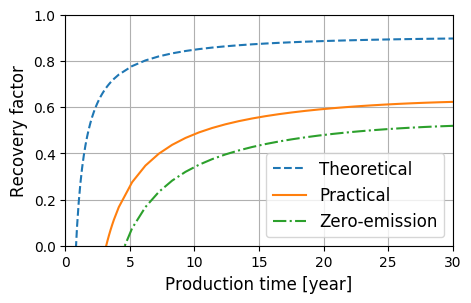

4-element Array{Int64,1}:
  0
 30
  0
  1

In [30]:
figure(figsize=(5,3))
plot(float(t[1:ind_life])/(365*24*3600),R_th, "--", label="Theoretical")
plot(float(t[1:ind_life])/(365*24*3600),R_pr, label="Practical")
plot(float(t[1:ind_life])/(365*24*3600),R_ze, "-.", label="Zero-emission")
legend(fontsize=12)
grid()
xlabel("Production time [year]", fontsize=12)
ylabel("Recovery factor", fontsize=12)
#yscale("log")
axis([0,30, 0,1])
# cumsum(rand(10))

The point at which the recovery factor is zero shows the time at which all the initial exergy consumption is returned (or paid back) by the geothermal reservoir.
## Recovery factor for all cases

In [46]:
df_res[:csv_name]

150-element DataArrays.DataArray{String,1}:
 "Q-50.0-L-500.0-k0.02.csv" 
 "Q-50.0-L-650.0-k0.02.csv" 
 "Q-50.0-L-800.0-k0.02.csv" 
 "Q-50.0-L-900.0-k0.02.csv" 
 "Q-50.0-L-1000.0-k0.02.csv"
 "Q-50.0-L-500.0-k0.05.csv" 
 "Q-50.0-L-650.0-k0.05.csv" 
 "Q-50.0-L-800.0-k0.05.csv" 
 "Q-50.0-L-900.0-k0.05.csv" 
 "Q-50.0-L-1000.0-k0.05.csv"
 "Q-50.0-L-500.0-k0.1.csv"  
 "Q-50.0-L-650.0-k0.1.csv"  
 "Q-50.0-L-800.0-k0.1.csv"  
 ⋮                          
 "Q-250.0-L-900.0-k0.2.csv" 
 "Q-250.0-L-1000.0-k0.2.csv"
 "Q-250.0-L-500.0-k0.5.csv" 
 "Q-250.0-L-650.0-k0.5.csv" 
 "Q-250.0-L-800.0-k0.5.csv" 
 "Q-250.0-L-900.0-k0.5.csv" 
 "Q-250.0-L-1000.0-k0.5.csv"
 "Q-250.0-L-500.0-k1.0.csv" 
 "Q-250.0-L-650.0-k1.0.csv" 
 "Q-250.0-L-800.0-k1.0.csv" 
 "Q-250.0-L-900.0-k1.0.csv" 
 "Q-250.0-L-1000.0-k1.0.csv"

In [47]:
# create empty data frames to save the analyzed files
df_geothermal = DataFrame(q_m3_s=[], k_m2=[], L_m=[], t_life_s=[], R_th=[], R_pr=[], R_ze=[], c_CO2=[])

i = 0
for fn in df_res[:csv_name]
    i=i+1
    Q    = df_res[:q_m3_h][i]/3600  # m3/s
    perm = df_res[:k_D][i]*1e-12    # m2
    L    = df_res[:L_m][i]          # m
    println(fn)
    t1 = readtable(fn)
    # deleterows!(t1,find(isna(t1[:,:Time_s_])))
    ind_life = find(t1[:T_K].<=(70+273.15))[1]
    t=float(t1[:T_s][1:ind_life])    # [s] simulation time
    t_life   = t[ind_life]
    Th = float(t1[:T_K][1:ind_life]) # [K] hot water temperature
    dp_res = float(t1[:dp_Pa][1:ind_life]) # [Pa] pressure drop in the reservoir
    u_pipe = Q/A_pipe                # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    R_th = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
    push!(df_geothermal, [Q, perm, L, t_life, R_th, R_pr, R_ze, c])
end

Q-50.0-L-500.0-k0.02.csv
Q-50.0-L-650.0-k0.02.csv
Q-50.0-L-800.0-k0.02.csv
Q-50.0-L-900.0-k0.02.csv
Q-50.0-L-1000.0-k0.02.csv
Q-50.0-L-500.0-k0.05.csv
Q-50.0-L-650.0-k0.05.csv
Q-50.0-L-800.0-k0.05.csv
Q-50.0-L-900.0-k0.05.csv
Q-50.0-L-1000.0-k0.05.csv
Q-50.0-L-500.0-k0.1.csv
Q-50.0-L-650.0-k0.1.csv
Q-50.0-L-800.0-k0.1.csv
Q-50.0-L-900.0-k0.1.csv
Q-50.0-L-1000.0-k0.1.csv
Q-50.0-L-500.0-k0.2.csv
Q-50.0-L-650.0-k0.2.csv
Q-50.0-L-800.0-k0.2.csv
Q-50.0-L-900.0-k0.2.csv
Q-50.0-L-1000.0-k0.2.csv
Q-50.0-L-500.0-k0.5.csv
Q-50.0-L-650.0-k0.5.csv
Q-50.0-L-800.0-k0.5.csv
Q-50.0-L-900.0-k0.5.csv
Q-50.0-L-1000.0-k0.5.csv
Q-50.0-L-500.0-k1.0.csv
Q-50.0-L-650.0-k1.0.csv
Q-50.0-L-800.0-k1.0.csv
Q-50.0-L-900.0-k1.0.csv
Q-50.0-L-1000.0-k1.0.csv
Q-100.0-L-500.0-k0.02.csv
Q-100.0-L-650.0-k0.02.csv
Q-100.0-L-800.0-k0.02.csv
Q-100.0-L-900.0-k0.02.csv
Q-100.0-L-1000.0-k0.02.csv
Q-100.0-L-500.0-k0.05.csv
Q-100.0-L-650.0-k0.05.csv
Q-100.0-L-800.0-k0.05.csv
Q-100.0-L-900.0-k0.05.csv
Q-100.0-L-1000.0-k0.05.csv
Q-

In [54]:
writetable("geothermal_final_results.csv", df_geothermal)

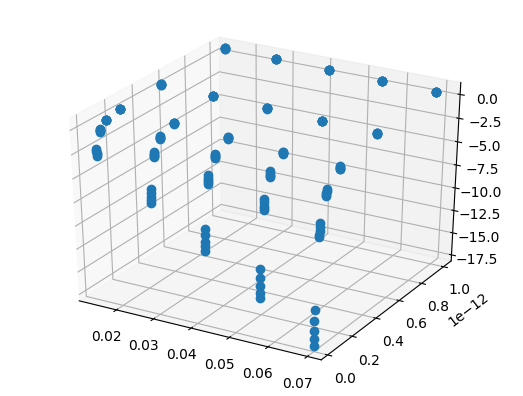

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7fcee6d5d5d0>

In [49]:
plot3D(df_geothermal[:q_m3_s], df_geothermal[:k_m2], df_geothermal[:R_pr], "o")

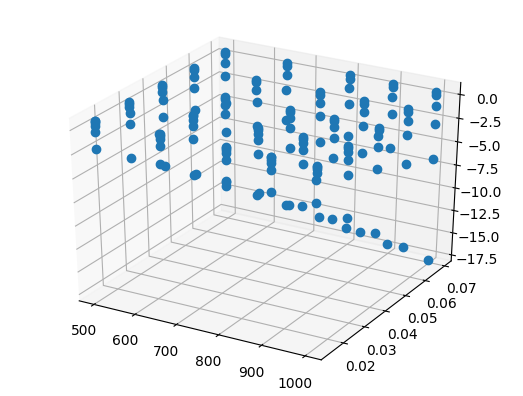

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7fcee6b1a690>

In [53]:
plot3D(df_geothermal[:L_m], df_geothermal[:q_m3_s], df_geothermal[:R_pr], "o")

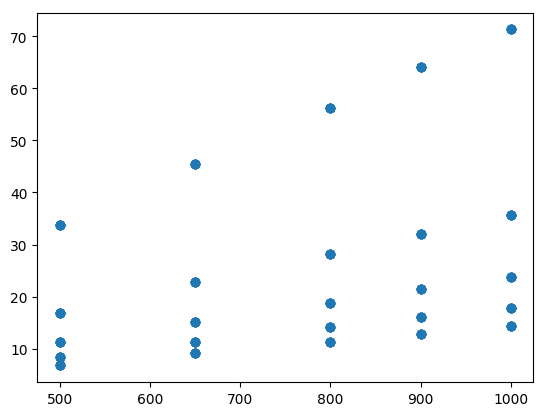

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcf0d5dfe10>

In [51]:
plot(df_geothermal[:L_m], df_geothermal[:t_life_s]/365/24/3600, "o")

## Effect of permeability

In [47]:
f_name = ["Geothermal_Q150_2Q150-20mD-L800.csv" 
"Geothermal_Q150_2Q150-50mD-L800.csv"
"Geothermal_Q150_2Q150-100mD-L800.csv"
"Geothermal_Q150_2Q150-500mD-L800.csv"
"Geothermal_Q150_2Q150-1D-L800.csv"]
i=0
R_th=zeros(5)
R_pr=zeros(5)
R_ze=zeros(5)
c=zeros(5)
for fn in f_name
    i=i+1
    Q=100/3600 # m^3/s
    t1 = readtable(fn)
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

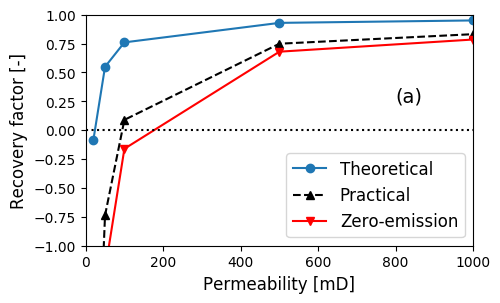

In [48]:
figure(figsize=(5,3))
plot(perm_range, R_th, "-o", perm_range, R_pr, "--^k", perm_range, R_ze, "-vr")
xlabel("Permeability [mD]", fontsize=12)
ylabel("Recovery factor [-]", fontsize=12)
legend(["Theoretical", "Practical", "Zero-emission"], loc=4, fontsize=12)
plot([0, 1000], [0, 0], ":k")
text(800, 0.25, "(a)", fontsize=14)
axis([0, 1000, -1.0, 1.0])
savefig("perm_effect.svg")

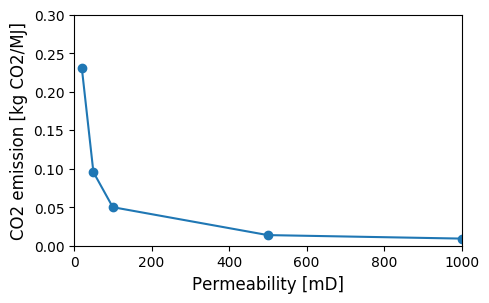

In [49]:
figure(figsize=(5,3))
plot(perm_range, c, "-o")
xlabel("Permeability [mD]", fontsize=12)
ylabel("CO2 emission [kg CO2/MJ]", fontsize=12)
#legend(["Theoretical", "Practical", "Zero-emission"], loc=4, fontsize=12)
axis([0, 1000, 0.0, 0.3])
savefig("perm_effect_CO2_emission.svg")

## Effect of permeability: higher flow rate

In [31]:
f_name = ["Geothermal_Q250_Q250-20mD-L800.csv"
    "Geothermal_Q250_Q250-50mD-L800.csv"
    "Geothermal_Q250_Q250-100mD-L800.csv"
    "Geothermal_Q250_Q250-500mD-L800.csv" 
    "Geothermal_Q250_Q250-1D-L800.csv"]
i=0
R_th=zeros(5)
R_pr=zeros(5)
R_ze=zeros(5)
c=zeros(5)
for fn in f_name
    i=i+1
    Q=250/3600 # m^3/s
    t1 = readtable(fn)
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

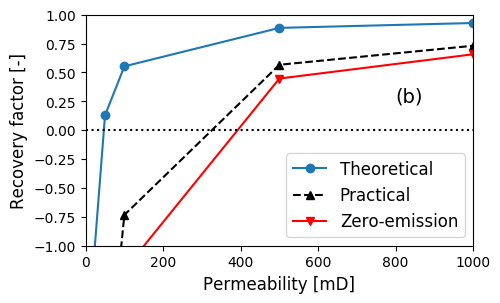

In [32]:
figure(figsize=(5,3))
plot(perm_range, R_th, "-o", perm_range, R_pr, "--^k", perm_range, R_ze, "-vr")
xlabel("Permeability [mD]", fontsize=12)
ylabel("Recovery factor [-]", fontsize=12)
legend(["Theoretical", "Practical", "Zero-emission"], loc=4, fontsize=12)
plot([0, 1000], [0, 0], ":k")
text(800, 0.25, "(b)", fontsize=14)
axis([0, 1000, -1.0, 1.0])
savefig("perm_effect_high_flow.svg")

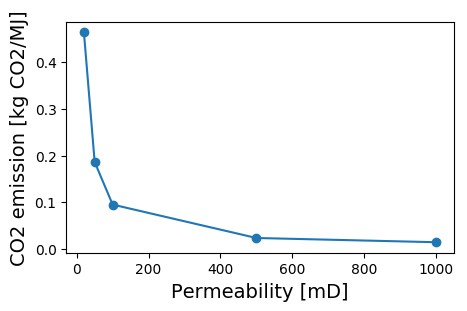

In [33]:
figure(figsize=(5,3))
plot(perm_range, c, "-o")
xlabel("Permeability [mD]", fontsize=14)
ylabel("CO2 emission [kg CO2/MJ]", fontsize=14)
#legend(["Theoretical", "Practical", "Zero-emission"], loc=4, fontsize=12)
savefig("perm_effect_CO2_emission_high_flow.svg")

## Effect of flow rate and well spacing

In [136]:
f_name = ["Geothermal_Q100_Q100-100mD-L470.csv", "Geothermal_Q150_Q150-100mD-L600.csv",
    "Geothermal_Q200_Q200-100mD-L700.csv", "Geothermal_Q250_Q250-100mD-L800.csv"]
i=0
R_th=zeros(4)
R_pr=zeros(4)
R_ze=zeros(4)
c=zeros(4)
for fn in f_name
    i=i+1
    Q=Q_range[i] # m^3/s
    t1 = readtable(fn)
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    #Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

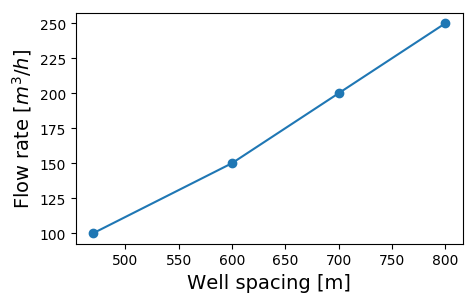

In [137]:
figure(figsize=(5,3))
plot(L_range, Q_range*3600, "-o")
xlabel("Well spacing [m]", fontsize=12)
ylabel("Flow rate "*L"[m^3/h]", fontsize=12)
savefig("well_space_flow_rate.svg")

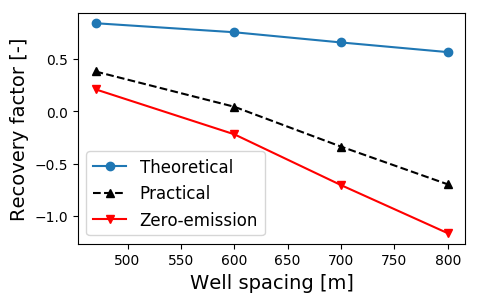

In [138]:
figure(figsize=(5,3))
plot(L_range, R_th, "-o", L_range, R_pr, "--^k", L_range, R_ze, "-vr")
xlabel("Well spacing [m]", fontsize=12)
ylabel("Recovery factor [-]", fontsize=12)
legend(["Theoretical", "Practical", "Zero-emission"], loc=3, fontsize=12)
savefig("well_space.svg")

## flow rate: 500 mD

In [139]:
f_name = ["Geothermal_Q100_Q100-500mD-L470.csv", "Geothermal_Q150_Q150-500mD-L600.csv",
    "Geothermal_Q200_Q200-500mD-L700.csv", "Geothermal_Q250_Q250-500mD-L800.csv"]
i=0
R_th=zeros(4)
R_pr=zeros(4)
R_ze=zeros(4)
c=zeros(4)
for fn in f_name
    i=i+1
    Q=Q_range[i] # m^3/s
    t1 = readtable(fn)
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

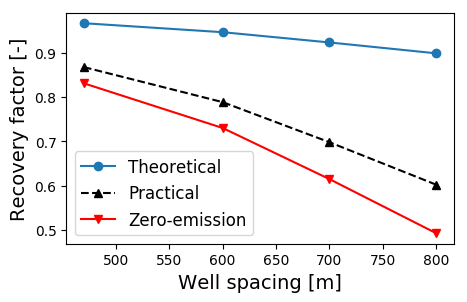

In [140]:
figure(figsize=(5,3))
plot(L_range, R_th, "-o", L_range, R_pr, "--^k", L_range, R_ze, "-vr")
xlabel("Well spacing [m]", fontsize=14)
ylabel("Recovery factor [-]", fontsize=14)
legend(["Theoretical", "Practical", "Zero-emission"], loc=3, fontsize=12)
savefig("well_space_500.svg")

## flow rate: 50 mD

In [141]:
f_name = ["Geothermal_Q100_Q100-50mD-L470.csv", "Geothermal_Q150_Q150-50mD-L600.csv",
    "Geothermal_Q200_Q200-50mD-L700.csv", "Geothermal_Q250_Q250-50mD-L800.csv"]
i=0
R_th=zeros(4)
R_pr=zeros(4)
R_ze=zeros(4)
c=zeros(4)
for fn in f_name
    i=i+1
    Q=Q_range[i] # m^3/s
    t1 = readtable(fn)
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    Ex_prod = Q*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

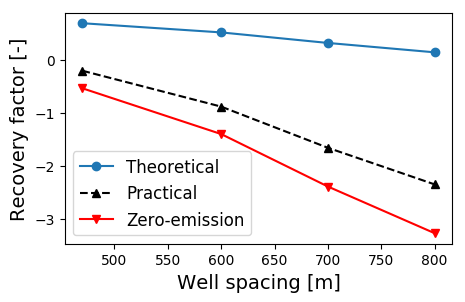

In [142]:
figure(figsize=(5,3))
plot(L_range, R_th, "-o", L_range, R_pr, "--^k", L_range, R_ze, "-vr")
xlabel("Well spacing [m]", fontsize=14)
ylabel("Recovery factor [-]", fontsize=14)
legend(["Theoretical", "Practical", "Zero-emission"], loc=3, fontsize=12)
savefig("well_space_50.svg")

# NOT YET THROWN AWAY
```m
i=0;
%for perm = 3e-14:0.1e-14:10e-14
for Q = 100/3600:100/3600:1000/3600
    i=i+1;
% calculation starts here ----------------------------------------------->
    m_steel = nwells*pi()/4*((D_well+2*t_tube)^2-D_well^2)*depth*rho_steel; % [kg]
    m_cement = nwells*pi()/4* ...
        ((D_well+2*t_tube+2*t_cement)^2-(D_well+2*t_tube)^2)*depth*rho_cement; % [kg]
    A_res = W*H; % [m^2] reservoir cross section
    A_pipe = pi()/4*D_well^2;
    u_res = Q/A_res; % [m/s] Darcy velocity
    u_pipe = Q/A_pipe; % [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water; % Reynolds number
    
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2; % [Pa] pressure drop in pipes
    dp_res = mu_water/perm*u_res*L; % [Pa] pressure drop in the reservoir
    Ex_pump = Q*(dp_pipe+dp_res)/1000;
    Ex_pipe_th=(m_steel*ex_steel_th+m_cement*ex_cement+ ...
        nwells*depth*ex_dril)/t_life; % [kJ] theoretical pipe exergy
    Ex_th = Ex_pump+Ex_pipe_th;
    Ex_pipe_pr=(m_steel*ex_steel+m_cement*ex_cement+ ...
        nwells*depth*ex_dril)/t_life; % [kJ] practical pipe exergy
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr; % [kJ] practical pumping exergy
    heat_prod = Q*rho_water*cp_water*(Th-T0) # [kJ] extracted heat
    Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    R_th(i) = (Ex_prod-Ex_th)/Ex_prod; % theoretical recovery factor
    R_pr(i) = (Ex_prod-Ex_prac)/Ex_prod; % theoretical recovery factor
    carbon_em = Ex_prac*c_methane; % [kg CO2]
    Ex_ccs = carbon_em*ex_ccs; % [kJ] CCS exergy
    R_ze(i) = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod; % zero-emission recovery factor
    c(i) = carbon_em/Ex_prod*1000; % [kg CO2/MJ]
% end of calculation ----------------------------------------------->

end

 %plot(perm, R_th, 'o', perm, R_pr, '^');
 Q = 100/3600:100/3600:1000/3600;
 plot(Q, R_th, Q, R_th, 'o', ...
     Q, R_pr, Q, R_pr, '^', ...
     Q, R_ze, Q, R_ze, 's');
 xlabel('flow rate (m^3/s)');
perm = 3e-14:0.1e-14:10e-14;
%plot(perm, R_th, perm, R_th, 'o', ...
%    perm, R_pr, perm, R_pr, '^', ...
%    perm, R_ze, perm, R_ze, 's');
%xlabel('Permeability [m^2]');
ylabel('Recovery factors');
legend('Theoretical', '','Practical', '', 'Zero-emission','');
```

In [87]:
# file_list = readdir()
# f_list = Array{Any}(20)
# j=0
# for i in eachindex(file_list)
#     if file_list[i][end-2:end]=="csv"
#         j+=1
#         f_list[j] = file_list[i]
#     end
# end
f_list = 
["Geothermal_Q100_Q100-100mD-L470.csv" 
 "Geothermal_Q100_Q100-1D-L470.csv"    
 "Geothermal_Q100_Q100-20mD-L470.csv"  
 "Geothermal_Q100_Q100-500mD-L470.csv" 
 "Geothermal_Q100_Q100-50mD-L470.csv"  
 "Geothermal_Q150_2Q150-100mD-L800.csv"
 "Geothermal_Q150_2Q150-1D-L800.csv"   
 "Geothermal_Q150_2Q150-20mD-L800.csv" 
 "Geothermal_Q150_2Q150-500mD-L800.csv"
 "Geothermal_Q150_2Q150-50mD-L800.csv" 
 "Geothermal_Q150_Q150-100mD-L600.csv" 
 "Geothermal_Q150_Q150-1D-L600.csv"    
 "Geothermal_Q150_Q150-20mD-L600.csv"  
 "Geothermal_Q150_Q150-500mD-L600.csv" 
 "Geothermal_Q150_Q150-50mD-L600.csv"  
 "Geothermal_Q200_Q200-100mD-L700.csv" 
 "Geothermal_Q200_Q200-1D-L700.csv"    
 "Geothermal_Q200_Q200-20mD-L700.csv"  
 "Geothermal_Q200_Q200-500mD-L700.csv" 
 "Geothermal_Q200_Q200-50mD-L700.csv"  
 "Geothermal_Q250_Q250-100mD-L800.csv" 
 "Geothermal_Q250_Q250-1D-L800.csv"    
 "Geothermal_Q250_Q250-20mD-L800.csv"  
 "Geothermal_Q250_Q250-500mD-L800.csv" 
 "Geothermal_Q250_Q250-50mD-L800.csv"]
# flow[m3/h] perm[mD] L[m]
sim_params = 
[100 100 470
100 1000 470
100 20   470
100 500  470
100 50   470
150 100  600
150 1000 600
150 20   600
150 500  600
150 50   600
150 100  800
150 1000 800
150 20   800
150 500  800
150 50   800
200 100  700
200 1000 700
200 20   700
200 500  700
200 50   700
250 100  800
250 1000 800
250 20   800
250 500  800
250 50   800]

25×3 Array{Int64,2}:
 100   100  470
 100  1000  470
 100    20  470
 100   500  470
 100    50  470
 150   100  600
 150  1000  600
 150    20  600
 150   500  600
 150    50  600
 150   100  800
 150  1000  800
 150    20  800
 150   500  800
 150    50  800
 200   100  700
 200  1000  700
 200    20  700
 200   500  700
 200    50  700
 250   100  800
 250  1000  800
 250    20  800
 250   500  800
 250    50  800

In [26]:
find(sim_params[:,2].==100)
length(f_list)

25

In [92]:
i    = 0
n_data = length(f_list)
R_th = zeros(n_data)
R_pr = zeros(n_data)
R_ze = zeros(n_data)
Q    = sim_params[:, 1]/3600       # m3/s
perm = sim_params[:, 2]/1000*1e-12 # m2
L    = sim_params[:, 3]            # m
c    = zeros(n_data)
for fn in f_list
    i=i+1
    println(fn)
    t1 = readtable(fn)
    deleterows!(t1,find(isna(t1[:,:Time_s_])))
    t=float(t1[:Time_s_]) # [s] simulation time
    Th = float(t1[:T_out])+273.15 # [K] hot water temperature
    u_pipe = Q[i]/A_pipe; # [m/s] velocity of water in wells
    Re = rho_water*u_pipe*D_well/mu_water # Reynolds number
    f=fric_factor(Re)
    dp_pipe = nwells*rho_water*f*depth/D_well*u_pipe^2/2 # [Pa] pressure drop in pipes
    dp_res = float(t1[:Dp_Mpa_])*1e6 # [Pa] pressure drop in the reservoir
    Ex_pump = trapz(t,Q[i]*(dp_pipe+dp_res)/1000)
    Ex_th = Ex_pump+Ex_pipe_th
    Ex_prac = Ex_pump/eta_driver/eta_pp/eta_pump+Ex_pipe_pr # [kJ] practical pumping exergy
    heat_prod = Q[i]*rho_water*cp_water*(Th-T_in) # [kJ] extracted heat
    # Ex_prod = trapz(t,heat_prod.*(1-T0./Th)) # [kJ] extracted exergy
    Ex_prod = Q[i]*rho_water*trapz(t, water_exergy(Th, p0, T0, p0)-
          water_exergy(T_in, p0, T0, p0))
    Ex_prod = Ex_prod/1000 # J to kJ
    R_th[i] = (Ex_prod-Ex_th)/Ex_prod # theoretical recovery factor
    R_pr[i] = (Ex_prod-Ex_prac)/Ex_prod # theoretical recovery factor
    carbon_em = Ex_prac*c_methane # [kg CO2]
    Ex_ccs = carbon_em*ex_ccs # [kJ] CCS exergy
    R_ze[i] = (Ex_prod-Ex_prac-Ex_ccs)/Ex_prod # zero-emission recovery factor
    c[i] = carbon_em/Ex_prod*1000 # [kg CO2/MJ]
end

Geothermal_Q100_Q100-100mD-L470.csv
Geothermal_Q100_Q100-1D-L470.csv
Geothermal_Q100_Q100-20mD-L470.csv
Geothermal_Q100_Q100-500mD-L470.csv
Geothermal_Q100_Q100-50mD-L470.csv
Geothermal_Q150_2Q150-100mD-L800.csv
Geothermal_Q150_2Q150-1D-L800.csv
Geothermal_Q150_2Q150-20mD-L800.csv
Geothermal_Q150_2Q150-500mD-L800.csv
Geothermal_Q150_2Q150-50mD-L800.csv
Geothermal_Q150_Q150-100mD-L600.csv
Geothermal_Q150_Q150-1D-L600.csv
Geothermal_Q150_Q150-20mD-L600.csv
Geothermal_Q150_Q150-500mD-L600.csv
Geothermal_Q150_Q150-50mD-L600.csv
Geothermal_Q200_Q200-100mD-L700.csv
Geothermal_Q200_Q200-1D-L700.csv
Geothermal_Q200_Q200-20mD-L700.csv
Geothermal_Q200_Q200-500mD-L700.csv
Geothermal_Q200_Q200-50mD-L700.csv
Geothermal_Q250_Q250-100mD-L800.csv
Geothermal_Q250_Q250-1D-L800.csv
Geothermal_Q250_Q250-20mD-L800.csv
Geothermal_Q250_Q250-500mD-L800.csv
Geothermal_Q250_Q250-50mD-L800.csv


In [93]:
# Q=250, L = 800
ind      = [11:15; 21:25]
spl_R_pr = Spline2D(perm[ind], Q[ind], R_pr[ind], kx=1, ky=1, s=16)
Qi       = collect(linspace(minimum(Q[ind]), maximum(Q[ind]), 20))
permi    = collect(linspace(minimum(perm[ind]), maximum(perm[ind]), 20))
R_pri    = evalgrid(spl_R_pr, permi, Qi)

20×20 Array{Float64,2}:
 -2.20258      -2.25847    -2.31436    …  -3.90693    -4.25921    -4.61149  
 -1.25511      -1.35026    -1.4454        -2.81194    -2.88326    -2.95457  
 -0.344254     -0.476616   -0.608978      -1.75584    -1.55867    -1.36151  
 -0.258151     -0.381789   -0.505427      -1.57585    -1.39135    -1.20685  
 -0.172047     -0.286962   -0.401876      -1.39587    -1.22403    -1.05219  
 -0.0859442    -0.192135   -0.298325   …  -1.21588    -1.05671    -0.897532 
  0.000159038  -0.0973077  -0.194774      -1.0359     -0.889387   -0.742873 
  0.0862623    -0.0024806  -0.0912235     -0.855916   -0.722065   -0.588214 
  0.172366      0.0923465   0.0123274     -0.675932   -0.554743   -0.433555 
  0.258469      0.187174    0.115878      -0.495948   -0.387422   -0.278896 
  0.344572      0.282001    0.219429   …  -0.315963   -0.2201     -0.124237 
  0.430675      0.376828    0.32298       -0.135979   -0.0527784   0.0304221
  0.516779      0.471655    0.426531       0.0440054

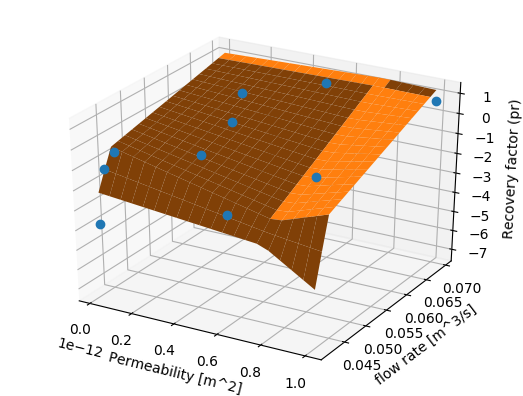

PyObject <matplotlib.text.Text object at 0x7fc3565e60d0>

In [94]:
plot3D(perm[ind], Q[ind], R_pr[ind], "o")
surf(permi, Qi, R_pri)
xlabel("Permeability [m^2]")
ylabel("flow rate [m^3/s]")
zlabel("Recovery factor (pr)")